# Generative Models for Random Graphs

## Prerequisites

First, we need to set up our Python environment that has PyTorch, PyTorch Geometric and PathpyG installed. Depending on where you are executing this notebook, this might already be (partially) done. E.g. Google Colab has PyTorch installed by default so we only need to install the remaining dependencies. The DevContainer that is part of our GitHub Repository on the other hand already has all of the necessary dependencies installed. 

In the following, we install the packages for usage in Google Colab using Jupyter magic commands. For other environments comment in or out the commands as necessary. For more details on how to install `pathpyG` especially if you want to install it with GPU-support, we refer to our [documentation](https://www.pathpy.net/dev/getting_started/). Note that `%%capture` discards the full output of the cell to not clutter this tutorial with unnecessary installation details. If you want to print the output, you can comment `%%capture` out.

In [1]:
%%capture
# !pip install torch
# !pip install torch_geometric
# !pip install git+https://github.com/pathpy/pathpyG.git

## Motivation and Learning Objectives

`pathpyG` provides implementations for several basic generative models for random graphs, such as different variants of the Erdös-Renyi model for random graphs, the Molloy-Reed configuration model for random graphs with given degree sequence or distribution, or the Watts-Strogatz models for small-world graphs. 

These models are implemented in the module `pathpyG.algorithms.generative_models`. In this tutorial, we will learn how to use these models to generate random graphs with `pathpyG`.

We start by importing the necessary packages and modules.

In [2]:
import string

import numpy as np
from matplotlib import pyplot as plt

import pathpyG as pp

To generate a random Erdös-Renyi graph using the so-called $G(n,p)$ model where $n$ is the number of nodes and $p$ is the probability for each node pair to be connected, we can call: 

In [3]:
g = pp.algorithms.generative_models.erdos_renyi_gnp(n=20, p=0.2)
pp.plot(g);

By default, no self-loops are added. If we want self-loops to be generated with probability $p$ we can do this as follows (note that self-loops are currently not plotted):

In [4]:
g = pp.algorithms.generative_models.erdos_renyi_gnp(n=20, p=0.2, self_loops=True)
pp.plot(g);

This also works for directed networks and we can specify a given node ID mapping:

In [5]:
g = pp.algorithms.generative_models.erdos_renyi_gnp(
    n=20, p=0.2, directed=True, mapping=pp.IndexMap([x for x in string.ascii_lowercase])
)
pp.plot(g);

For the random realizations generated by the $G(n,p)$ model with connection probability $p$, we have an *expected* number of $p \cdot \binom{n}{2}$ edges, i.e. the number of edges in each realization varies.

We can use the alternative $G(n,m)$ formulation of the Erdös-Renyi model, which generates a fixed number of $m$ edges chosen uniformly at random:

In [6]:
g = pp.algorithms.generative_models.erdos_renyi_gnm(
    n=20, m=40, mapping=pp.IndexMap([x for x in string.ascii_lowercase])
)
print(g)
pp.plot(g);

Undirected graph with 26 nodes and 40 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}


Naturally, the maximum number of edges that we can create depends on the size of the graph (and whether edges are directed and whether we allow for self-loops). The following fails:

In [7]:
try:
    g = pp.algorithms.generative_models.erdos_renyi_gnm(
        n=20, m=195, mapping=pp.IndexMap([x for x in string.ascii_lowercase])
    )
except Exception as e:
    print(f"Error: {e}")

2025-11-07 16:52:41 - Given number of edges is larger than theoretical maximum
Error: Given number of edges is larger than theoretical maximum


To check how many edges a directed/undirected graph with/without self-loop can possibly have, you can use the `max_edges` function:

In [8]:
pp.algorithms.generative_models.max_edges(n=20, directed=False, self_loops=False)

190

We often use random graph models to generate randomized versions of empirical networks. For this prupose, `pathpyG` provides `_randomize` variants for random graph models, which can be used to automatically fit the model parameters to an empirical graph, thus generating a randomized version that preserves the corresponding aggregate characteristics defined by the model. 

Let's try this for randomized versions of the Karate club network, which we can load from the netzschleuder database:

In [9]:
g_karate = pp.io.read_netzschleuder_graph('karate', '77')
print(g_karate)

Undirected graph with 34 nodes and 77 edges
{   'Edge Attributes': {},
    'Graph Attributes': {   'analyses_average_degree': "<class 'float'>",
                            'analyses_degree_assortativity': "<class 'float'>",
                            'analyses_degree_std_dev': "<class 'float'>",
                            'analyses_diameter': "<class 'int'>",
                            'analyses_edge_properties': "<class 'list'>",
                            'analyses_edge_reciprocity': "<class 'float'>",
                            'analyses_global_clustering': "<class 'float'>",
                            'analyses_hashimoto_radius': "<class 'float'>",
                            'analyses_is_bipartite': "<class 'bool'>",
                            'analyses_is_directed': "<class 'bool'>",
                            'analyses_knn_proj_1': "<class 'float'>",
                            'analyses_knn_proj_2': "<class 'float'>",
                            'analyses_largest_compo

Using `erdos_renyi_gnm_randomize`, we obtain a random graph with the same number of nodes and edges.

In [10]:
r_karate = pp.algorithms.generative_models.erdos_renyi_gnm_randomize(g_karate)
print(r_karate)

Undirected graph with 34 nodes and 77 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}


Note that node, edge, and graph attributes are not preserved, but it is easy to add back those manually that you want to reassign.

In [11]:
r_karate.data.node_groups = g_karate.data.node_groups
print(r_karate)

Undirected graph with 34 nodes and 77 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {'node_groups': "<class 'torch.Tensor'> -> torch.Size([34])"}}


Using `erdos_renyi_gnp_randomize`, we obtain a random graph with the same number of nodes and where the *expected* number of edges matches the original graph, i.e. in each random realization the actual number of edges varies:

In [12]:
r_karate_1 = pp.algorithms.generative_models.erdos_renyi_gnp_randomize(g_karate)
r_karate_2 = pp.algorithms.generative_models.erdos_renyi_gnp_randomize(g_karate)
print(r_karate_1)
print(r_karate_2)

Undirected graph with 34 nodes and 76 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}
Undirected graph with 34 nodes and 67 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}


Plotting the distribution of edges in the random realization confirms that we get a distribution that is centered around the edge count of our empirical graph.

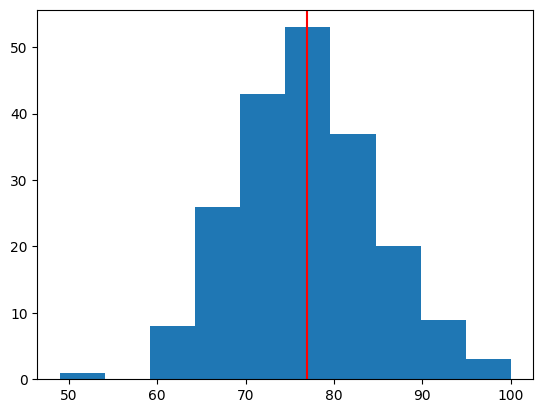

In [13]:
edge_counts = []
for i in range(200):
    r_karate = pp.algorithms.generative_models.erdos_renyi_gnp_randomize(g_karate)
    edge_counts.append(r_karate.m)
ax = plt.hist(edge_counts)
plt.axvline(x=g_karate.m, color='red')

We can finally use the Molloy-Reed configuration model to generate random graphs with a given degree sequence:

In [14]:
g = pp.algorithms.generative_models.molloy_reed([2,2,3,2,3])
print(pp.statistics.degree_sequence(g))
print(g)
pp.plot(g);

[2 2 3 2 3]
Undirected graph with 5 nodes and 6 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}


Not every sequence of integers is the degree sequence of a corresponding graph, the following thus fails:

In [15]:
try:
    g = pp.algorithms.generative_models.molloy_reed([2,2,6,2,3])
except Exception as e:
    print(f"Error: {e}")

2025-11-07 16:52:42 - given degree sequence is not graphic
Error: gicen degree sequence is not graphic


We can test whether a sequence of integers is graphic, i.e. whether we can use it to generate a Molloy-Reed random graph:

In [16]:
pp.algorithms.generative_models.is_graphic_erdos_gallai([2,2,6,2,3])

False

We can use the Molloy-Reed model to randomize empirical networks, generating a random graph with the same degree sequence but a randomized topology:

In [17]:
r_karate = pp.algorithms.generative_models.molloy_reed_randomize(g_karate)
print(r_karate)
print(pp.statistics.degree_sequence(g_karate))
print(pp.statistics.degree_sequence(r_karate))

Undirected graph with 34 nodes and 77 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}
[16  9 10  6  3  4  4  4  5  2  3  1  2  5  2  2  2  2  2  3  2  2  1  5
  3  3  2  4  3  4  4  6 12 16]
[16  9 10  6  3  4  4  4  5  2  3  1  2  5  2  2  2  2  2  3  2  2  1  5
  3  3  2  4  3  4  4  6 12 16]


Finally, the `generative_models` module also contains implementations of the Watts-Strogatz model as well as the stochastic block model. Different from the models above, those models cannot be used to randomize a graph though.

In [18]:
g = pp.algorithms.generative_models.watts_strogatz(n=100, s=2, p=0.1)
pp.plot(g);

To generate an undirected random graph based on the stochastic block model, we must minimally specify two parameters: 

The stochastic block matrix $M$ contains edge probabilities for all pairs of nodes where the source and target belong to different blocks. 

The block assignment vector $z$ assigns nodes to blocks (based on their index). The length of this vector implicitly determined the number of nodes.

In the example below, we generate a random graph with eight nodes, where the first four nodes `a` - `d` are assigned to block 0 and the last four nodes `e` - `h` are assigned to block 1. Edges between node pairs where both nodes are in block 0 are generated with probability $0.95$. If both nodes are in block 1 edges are generated with probability $0.85$. If the nodes are in different blocks, edges are generated with probability $0.1$.

In [21]:
M = np.matrix('0.95 0.15; 0.15 0.85')
print(M)
z = np.array([0, 0, 0, 0, 1, 1, 1, 1])

g = pp.algorithms.generative_models.stochastic_block_model(M, z, pp.IndexMap(list('abcdefgh')))
pp.plot(g, node_color=z.tolist());

[[0.95 0.15]
 [0.15 0.85]]


To generate a graph with three fully connected cliques, we can specify the parameters as follows:

In [20]:
M = np.matrix('1 0 0;0 1 0;0 0 1')
print(M)
z = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])
g = pp.algorithms.generative_models.stochastic_block_model(M, z, pp.IndexMap(list('abcdefghi')))
print(g)
pp.plot(g, node_color=z.tolist());

[[1 0 0]
 [0 1 0]
 [0 0 1]]
Undirected graph with 9 nodes and 9 edges
{'Edge Attributes': {}, 'Graph Attributes': {'num_nodes': "<class 'int'>"}, 'Node Attributes': {}}
